# Æther: Cosine Similarity-Based Plagiarism Detection System

## Overview

This notebook implements a plagiarism detection system for source code using cosine similarity. The system leverages the CodeBERTa pre-trained model to generate embeddings for code snippets, which are then compared using cosine similarity to determine if two code samples are similar enough to be considered plagiarized.

## Approach

- **Data Loading**: Efficiently load code files from the ConPlag Dataset.
- **Embedding Generation**: Use CodeBERTa to transform code into semantic vectors.
- **Similarity Calculation**: Compute cosine similarity between code pairs.
- **Classification**: Determine an optimal threshold for plagiarism detection.
- **Evaluation**: Assess system performance using standard metrics.


## 1. Environment Setup


In [19]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from typing import List

### 1.1 Seed Configuration


In [20]:
np.random.seed(42)
torch.manual_seed(42)

### 1.2 GPU Support

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 1.3 Model Initialization

Initialize the CodeBERTa tokenizer and the model. CodeBERTa is specifically designed for understanding programming languages and can effectively capture the semantic meaning of code sampels.


In [22]:
tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to(device)

## 2. Data Loading


In [23]:
def loadDataset(labels_path: str, base_dir: str) -> pd.DataFrame:
    """
    Load dataset efficiently by reading unique files only once.

    This function read labels from a CSV file and loads the corresponding source
    code files. It optimized I/O operations by loading each unique file only
    once.

    Args:
        labels_path (str): Path to the CSV file containing plagiarism labels
        base_dir (str): Base directory containing the source code files

    Returns:
        pandas.DataFrame: DataFrame containing file pairs and their plagiarism
                          labels

    Raises:
        FileNotFoundError: If labels file or base directory doesn't exist
        FileNotFoundError: If a referenced source code file isn't found
    """

    labels_path = Path(labels_path)
    base_dir = Path(base_dir)

    if not labels_path.exists() or not labels_path.is_file():
        raise FileNotFoundError(f"Labels file not found: {labels_path}")

    if not base_dir.exists() or not base_dir.is_dir():
        raise FileNotFoundError(f"Base directory not found: {base_dir}")

    df = pd.read_csv(labels_path)
    unique_ids = pd.concat([df["id1"], df["id2"]]).unique()

    files = {}
    for file_id in tqdm(unique_ids, desc="Loading files"):
        path = base_dir / f"{file_id}.java"

        if path.exists():
            try:
                files[file_id] = path.read_text(encoding="utf-8")

            except UnicodeDecodeError:
                files[file_id] = path.read_text(encoding="latin-1")

        else:
            raise FileNotFoundError(f"File not found: {path}")

    df["file1"] = df["id1"].map(files)
    df["file2"] = df["id2"].map(files)
    df["plagio"] = df["plagio"].astype(int)

    return df

## 3. Embeding Functions


In [24]:
def embed_batch(texts: List[str], batch_size: int = 16) -> np.ndarray:
    """
    Efficiently embed multiple text samples in batches.

    This function processes code snippets through the CodeBERTa model
    to generate embeddings. It optimizes memory usage be processing in
    batches and minimizing GPU transfers.

    Args:
        texts (list): List of text strings to embed
        batch_size (int, optional): Number of texts to process in each batch.
                                    Defaults to 16.

    Returns:
        numpy.ndarray: Array of embeddings, shape (len(texts), embedding_dim)
    """

    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(
            batch_texts, padding="longest", truncation=True, return_tensors="pt"
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        embeddings = outputs.pooler_output
        all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings) if all_embeddings else np.array([])

In [25]:
def embed(text: str) -> np.ndarray:
    """
    Embed a single text input.

    This function processes a single code snippet through the CodeBERTa model
    to generate an embedding vector.

    Args:
      text (str): Text string to embed

    Returns:
      numpy.ndarray: Embedding vector.
    """

    inputs = tokenizer(text, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = torch.mean(outputs.last_hidden_state, dim=1)[0]
    return embeddings.cpu().numpy()

## 4.0 Dataset Processing


In [26]:
def process_dataset(dataset: Dataset) -> Dataset:
    """
    Process dataset by embedding unique files only once.

    This function optimizes embedding generation by identifying unique files and
    embedding them only once. It then maps these embeddings back to the dataset.

    Args:
        dataset (datasets.Dataset): HuggingFace dataset containing file pairs

    Returns:
        datasets.Dataset: Dataset with added embedding columns
    """

    all_files = []
    file_to_idx = {}

    unique_files = set()
    for file1, file2 in zip(dataset["file1"], dataset["file2"]):
        unique_files.add(file1)
        unique_files.add(file2)

    all_files = list(unique_files)
    file_to_idx = {file: idx for idx, file in enumerate(all_files)}

    print(f"Embedding {len(all_files)} unique files...")

    all_embeddings = embed_batch(all_files, 128)
    file_to_embedding = {file: all_embeddings[idx] for file, idx in file_to_idx.items()}

    def add_embeddings(example):
        return {
            "embeddedFile1": file_to_embedding[example["file1"]],
            "embeddedFile2": file_to_embedding[example["file2"]],
        }

    return dataset.map(add_embeddings)

## 5.0 Cosine Similarity


In [27]:
def compute_cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """
    Compute cosine similarity between two vectors.

    Cosine similarity measures the cosine of the angle between two vectors,
    providing a measure of their semantic similarity.

    Args:
        vec1 (numpy.ndarray): First vector
        vec2 (numpy.ndarray): Second vector

    Returns:
        float: Cosine similarity value in range [-1, 1]
    """

    vec1_norm = vec1 / np.linalg.norm(vec1)
    vec2_norm = vec2 / np.linalg.norm(vec2)

    return np.dot(vec1_norm, vec2_norm)

In [28]:
def add_similarity_scores(dataset: Dataset) -> Dataset:
    """
    Add cosine similarity scores to dataset.

    This function calculates cosine similarity between embedded file pairs
    and adds the scores to the dataset.

    Args:
      dataset (datasets.Dataset): Dataset containing embedded file pairs

    Returns:
      datasets.Dataset: Dataset with added similarity column
    """

    def add_similarity(example):
        sim = compute_cosine_similarity(
            example["embeddedFile1"], example["embeddedFile2"]
        )

        return {"similarity": sim}

    return dataset.map(add_similarity)

## 6.0 Model Evaluation


In [29]:
def find_optimal_threshold(y_true: np.ndarray, y_scores: np.ndarray) -> float:
    """
    Find the optimal threshold for binary classification using ROC curve.

    This function determines the optimal threshold for converting similarity
    scores into binary predictions by maximizing the difference between true
    positive rate and false positive rate.

    Args:
        y_true (numpy.ndarray): Array of true binary labels
        y_scores (numpy.ndarray): Array of predicted scores

    Returns:
        float: Optimal threshold value
    """

    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [30]:
def evaluate_model(df: pd.DataFrame):
    """
    Evaluate the plagiarism detection model.

    This function:
    1. Finds the optimal threshold for classification
    2. Applies threshold to convert similarity scores to binary predictions
    3. Generates a classification report with precision, recall, and F1-score
    4. Visualizes results with confusion matrix and score distribution

    Args:
        df (pandas.DataFrame): DataFrame containing true labels and similarity
                               scores

    Returns:
        None: Results are printed and visualized
    """

    threshold = find_optimal_threshold(df["plagio"].values, df["similarity"].values)
    print(f"Optimal threshold: {threshold:.2f}")

    df["predicted"] = df["similarity"].apply(lambda x: 1 if x > threshold else 0)

    report = classification_report(df["plagio"], df["predicted"])
    print(report)
    cm = confusion_matrix(df["plagio"], df["predicted"])

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Not Plagiarized", "Plagiarized"]
    )
    disp.plot(
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=plt.gca(),
    )
    plt.title("Confusion Matrix")
    plt.show()

    # Plot the distribution of the similarity scores
    plt.figure(figsize=(10, 7))
    plt.hist(
        df["similarity"], bins=50, alpha=0.7, color="blue", label="Similarity Scores"
    )
    plt.axvline(threshold, color="red", linestyle="--")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Similarity Scores")
    plt.show()

## 7.0 Execution


Define paths


In [32]:
LABELS_PATH = "../labels/conplag_labels.csv"
BASE_DIR = "../datasets/conplag_preprocessed"

Loading the dataset


In [33]:
df = loadDataset(LABELS_PATH, BASE_DIR)
dataset = Dataset.from_pandas(df)

Loading files: 100%|██████████| 975/975 [00:00<00:00, 58846.88it/s]


Process dataset (generated embeddings)

In [34]:
embedded_dataset = process_dataset(dataset)

Embedding 946 unique files...


Embedding batches: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Compute similarity scores

In [35]:
print("Computing similarity scores...")
final_dataset = add_similarity_scores(embedded_dataset)

Computing similarity scores...


Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Optimal threshold: 0.96
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       660
           1       0.55      0.54      0.54       251

    accuracy                           0.75       911
   macro avg       0.69      0.69      0.69       911
weighted avg       0.75      0.75      0.75       911



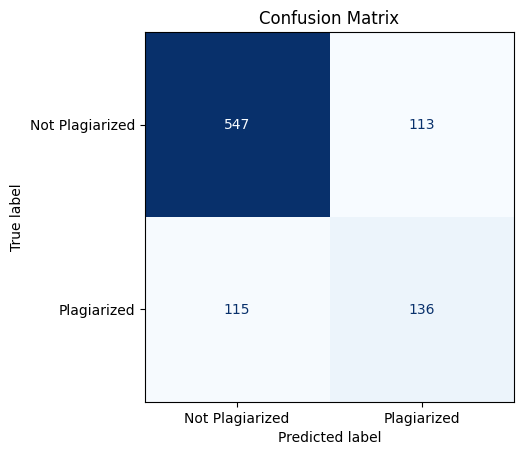

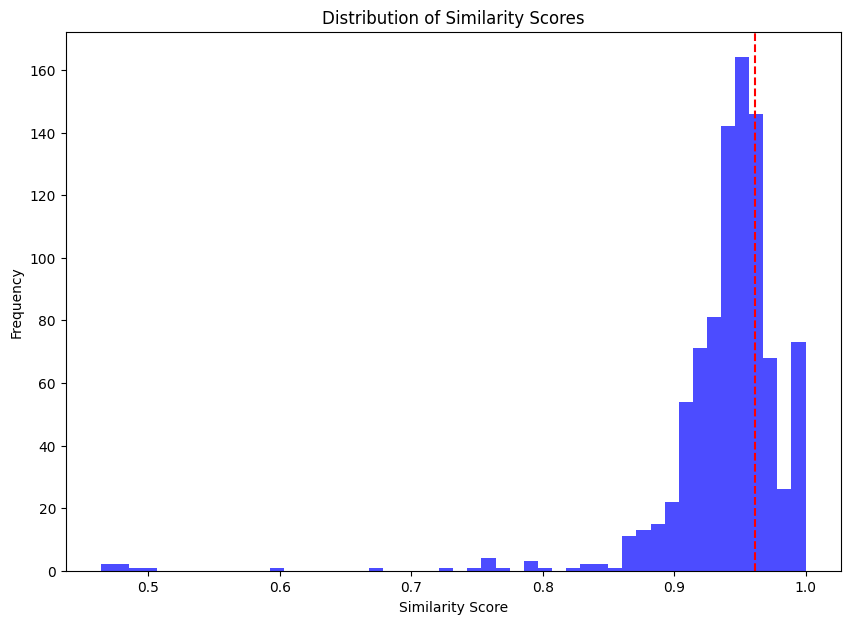

In [36]:
df = final_dataset.to_pandas()
evaluate_model(df)